In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import bz2
from tqdm import tqdm
import os

In [2]:
events = []
total_size = 0
for file_name in tqdm(os.listdir('../Data/')):
    if 'txt.bz2' in file_name:
        with bz2.open('../Data/{}'.format(file_name), 'r') as f:
            file = f.readlines()
            print('total shape of {} is ({}, {})'.format(file_name, len(file), len(file[0].split())))
            event_matrix = np.zeros((len(file), len(file[0].split())), dtype=np.int16)
            for ind, event in enumerate(file):
                event_matrix[ind, :] = [int(i) for i in event.split()]
            local_size = event_matrix.size * event_matrix.itemsize / 1024 / 1024 / 1024 # ~250 MB
            total_size += local_size
            print('Total size {}\t Local size {}'.format(total_size, local_size))
            events.append(event_matrix)

  0%|          | 0/14 [00:00<?, ?it/s]

total shape of event2.txt.bz2 is (30720, 4495)


  7%|▋         | 1/14 [02:15<29:23, 135.62s/it]

Total size 0.2572059631347656	 Local size 0.2572059631347656
total shape of event3.txt.bz2 is (30720, 4495)


 14%|█▍        | 2/14 [04:15<26:10, 130.90s/it]

Total size 0.5144119262695312	 Local size 0.2572059631347656
total shape of event1.txt.bz2 is (30720, 4495)


KeyboardInterrupt: 

In [39]:
events = np.row_stack(events)

In [41]:
with open('../Data/full_events.npy', 'wb') as f:
    np.save(f, events, allow_pickle=False)

### Start here

In [2]:
with open('../Data/full_events.npy', 'rb') as f:
    events = np.load(f, allow_pickle=False)

In [3]:
events

array([[    8,     0,     0, ...,  1801,  1805,  1803],
       [    8,     1,     0, ...,  1802,  1802,  1800],
       [    8,     2,     0, ...,  1804,  1803,  1793],
       ...,
       [    8, 30717,     1, ...,   499,   496,   496],
       [    8, 30718,     1, ...,   500,   502,   501],
       [    8, 30719,     1, ...,   502,   499,   496]], dtype=int16)

In [4]:
events.shape

(30720, 4495)

In [20]:
collection_channels = events[events[:, 2] == 1][:, 3:]
readout_channels = events[events[:, 2] == 0][:, 3:]

In [24]:
readout_channels

array([[1805, 1800, 1802, ..., 1801, 1805, 1803],
       [1803, 1801, 1803, ..., 1802, 1802, 1800],
       [1803, 1802, 1796, ..., 1804, 1803, 1793],
       ...,
       [1800, 1801, 1800, ..., 1805, 1797, 1795],
       [1797, 1794, 1797, ..., 1795, 1796, 1804],
       [1795, 1795, 1798, ..., 1799, 1803, 1799]], dtype=int16)

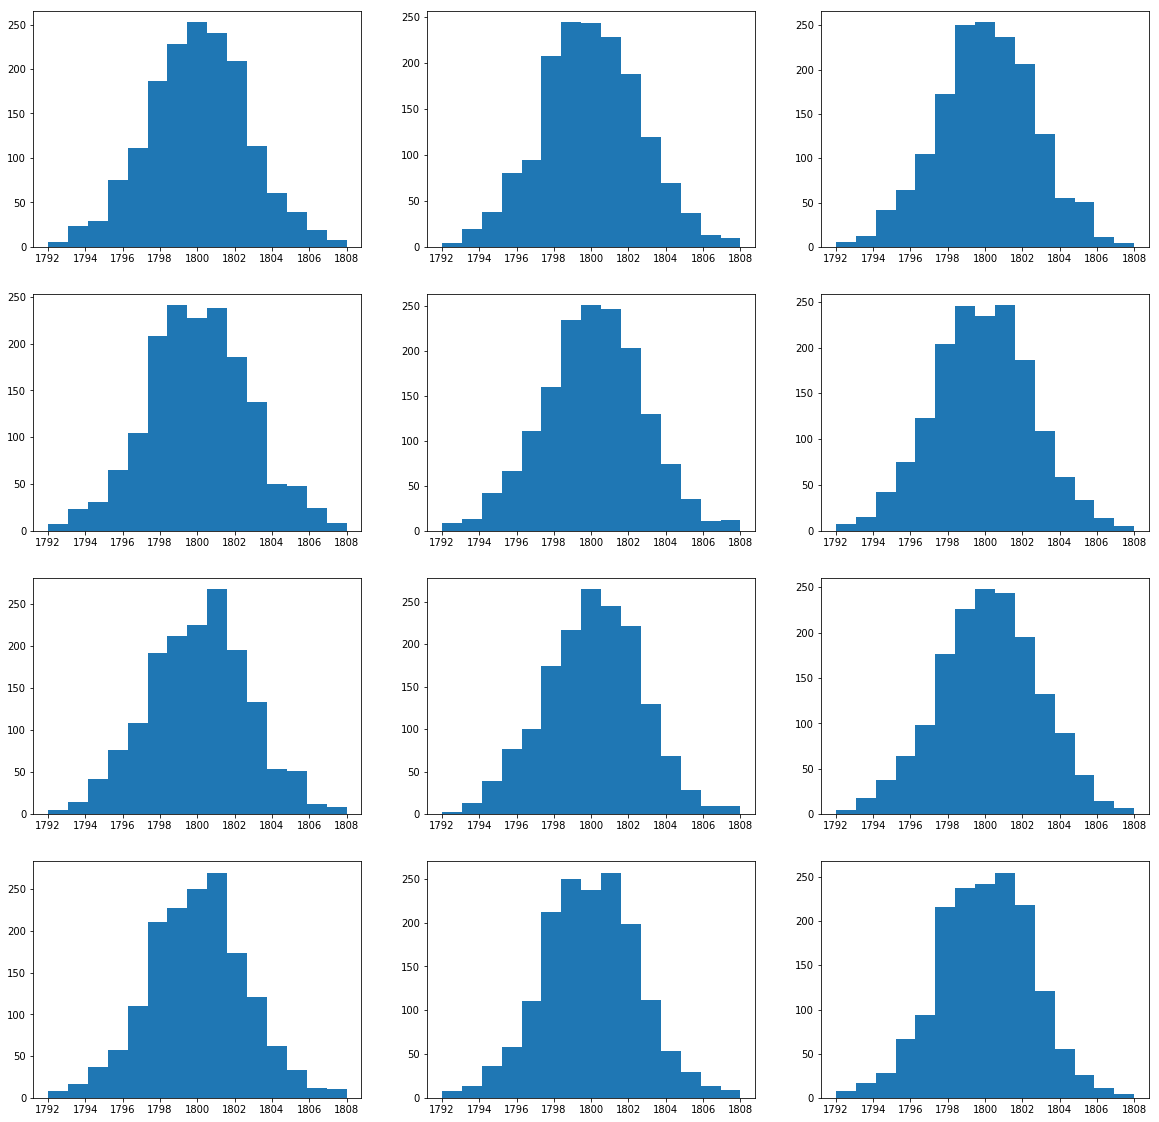

In [39]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
bbins = 15

for i in range(12):
    _, bbins, _ = axes[i%4][i//4].hist(readout_channels[i*1600:(i+1)*1600, 10], bins=bbins)
    
plt.show()

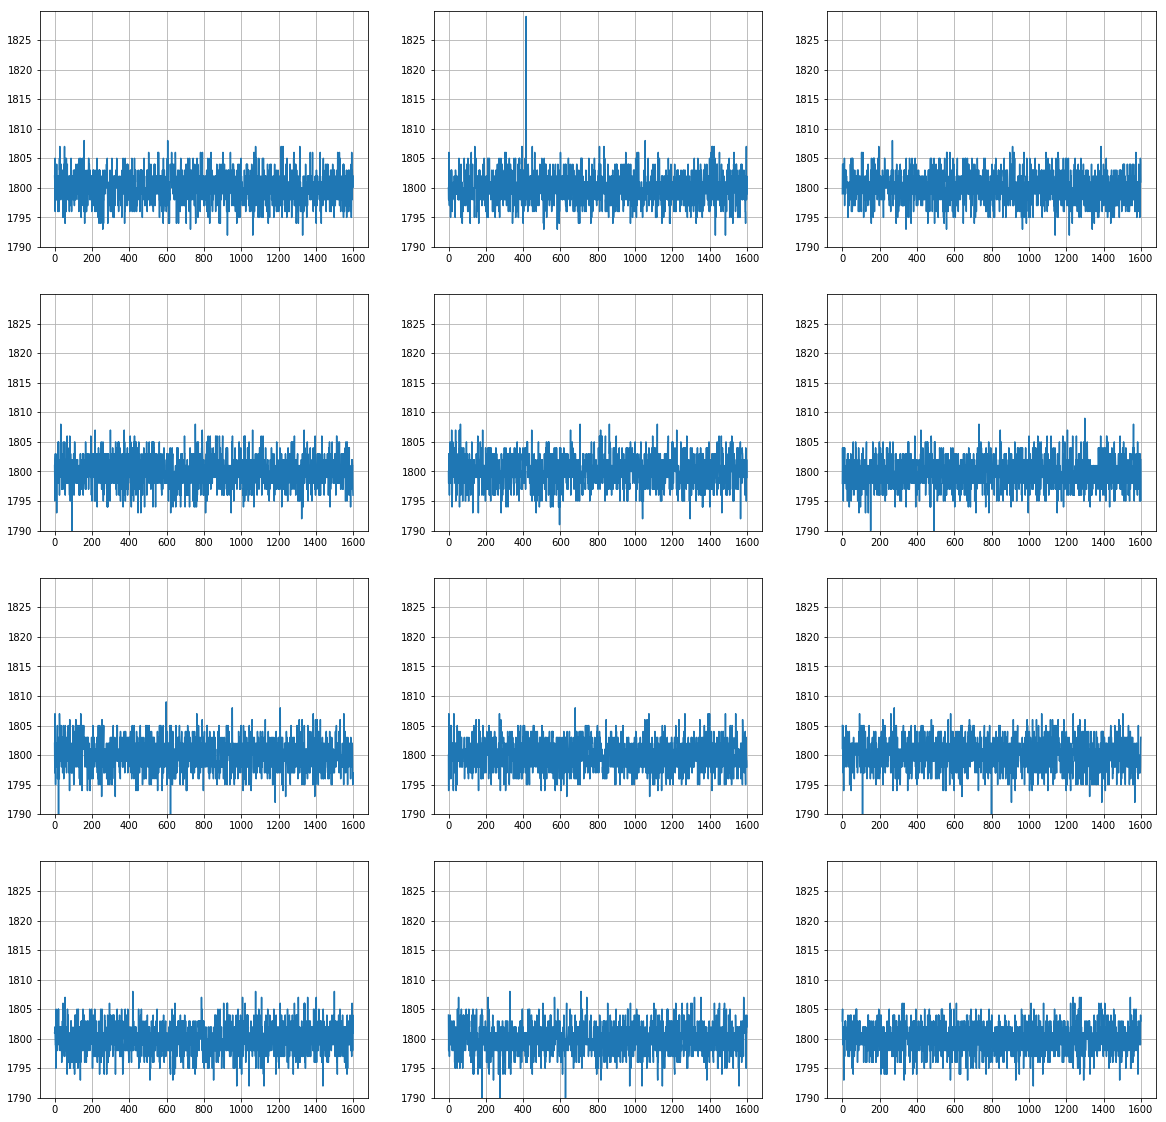

In [42]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i in range(12):
    axes[i%4][i//4].plot(readout_channels[i*1600:(i+1)*1600, 10])
    axes[i%4][i//4].set_yticks(np.arange(1790, 1830, 5))
    axes[i%4][i//4].set_ylim((1790, 1830))
    axes[i%4][i//4].grid()
    
plt.show()

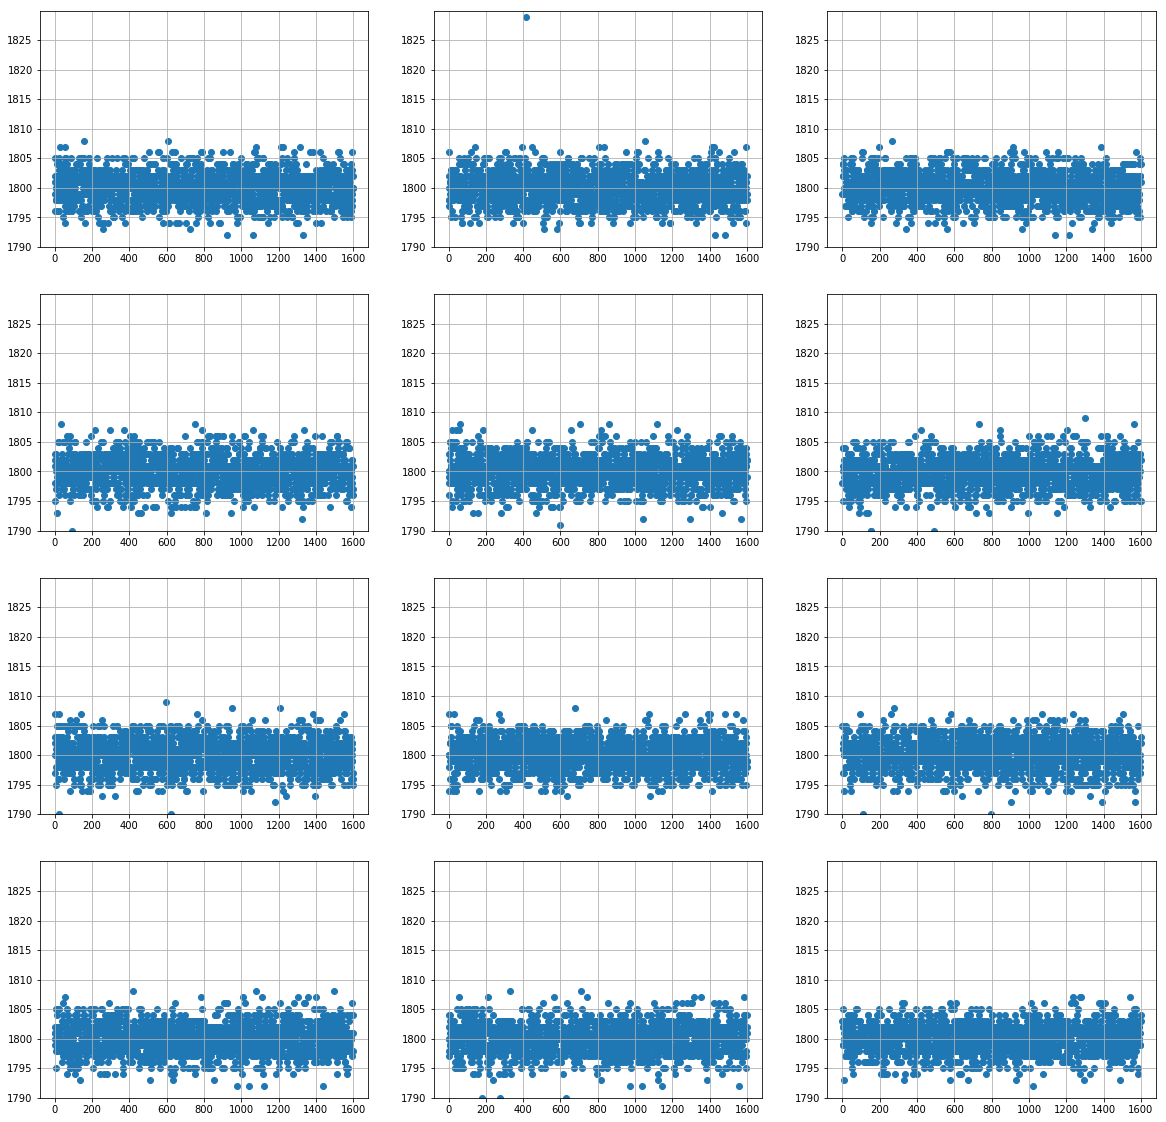

In [47]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for i in range(12):
    axes[i%4][i//4].scatter(range(1600), readout_channels[i*1600:(i+1)*1600, 10])
    axes[i%4][i//4].set_yticks(np.arange(1790, 1830, 5))
    axes[i%4][i//4].set_ylim((1790, 1830))
    axes[i%4][i//4].grid()
    
plt.show()

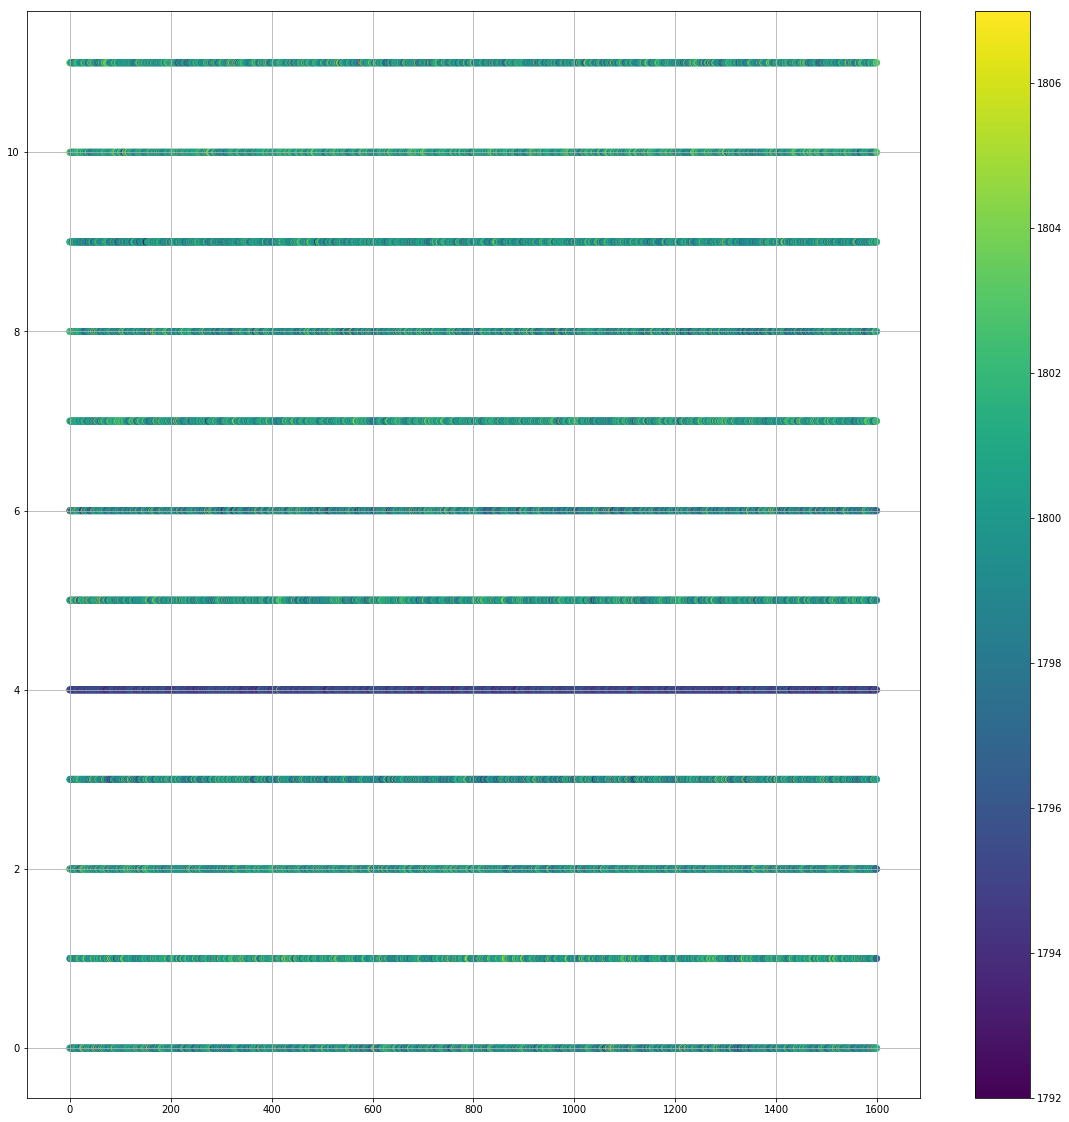

In [53]:
plt.figure(figsize=(20, 20))

for i in range(12):
    plt.scatter(range(1600), [i]*1600, c=readout_channels[i*1600:(i+1)*1600, 10])
    
plt.colorbar()
plt.grid()
plt.show()

In [48]:
readout_time = 

array([[1805, 1800, 1802, ..., 1801, 1805, 1803],
       [1803, 1801, 1803, ..., 1802, 1802, 1800],
       [1803, 1802, 1796, ..., 1804, 1803, 1793],
       ...,
       [1800, 1801, 1800, ..., 1805, 1797, 1795],
       [1797, 1794, 1797, ..., 1795, 1796, 1804],
       [1795, 1795, 1798, ..., 1799, 1803, 1799]], dtype=int16)

(array([ 132.,  653., 2111., 2177., 6310., 4798., 1499., 1226.,  258.,
          36.]),
 array([1792. , 1793.7, 1795.4, 1797.1, 1798.8, 1800.5, 1802.2, 1803.9,
        1805.6, 1807.3, 1809. ]),
 <a list of 10 Patch objects>)

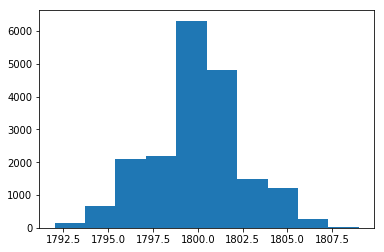

In [23]:
plt.hist(readout_channels[:, 1])

array([[   8,    0,    0, ..., 1801, 1805, 1803],
       [   8,    1,    0, ..., 1802, 1802, 1800],
       [   8,    2,    0, ..., 1804, 1803, 1793],
       ...,
       [   8, 1598,    0, ..., 1798, 1801, 1800],
       [   8, 1599,    0, ..., 1799, 1802, 1797],
       [   8, 1600,    1, ...,  505,  500,  499]], dtype=int16)